In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from src.serialization_lib import read_df_res_from_feather, read_df_debug_from_feather
from src.data_types import *
import pandas as pd
import statistics
import datetime

# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', 100)

In [3]:
INITIAL_PORTFOLIO_VALUE = 10000
PORTFOLIO_SIZE = 30
REBALANCE_DAYS = 90

BASE_METRIC = EvaluationMetric.EV_EBIT
TEST_METRIC = EvaluationMetric.P_B
STOCKS_UNIVERSE = StockUniverse.LARGE
PORTFOLIO_WEIGHT_STRATEGY = StockBasketWeightApproach.EQUAL_WEIGHTING

In [8]:
def plot_backtest(
    df: pd.DataFrame,
    base_metric: EvaluationMetric,
    test_metric: EvaluationMetric, 
    rebalance_days: int,
    portfolio_size: int,
    stocks_universe: StockUniverse
):
    df_to_plot = df[['base_price', 'test_price']]
    df_to_plot.plot(title=(
        f'{str(base_metric)} (base)'
        f' VS {str(test_metric)} (test)\n'
        f' Rebalance freq: {rebalance_days} days\n'
        f' Portfolio size: {portfolio_size} stocks\n'
        f' Universe of stocks: {str(stocks_universe)}'))

In [9]:
df_debug = read_df_debug_from_feather(REBALANCE_DAYS)
df_res = read_df_res_from_feather(REBALANCE_DAYS)

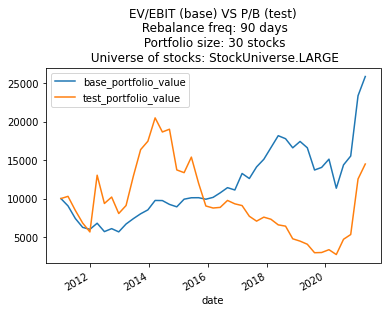

In [10]:
plot_backtest(df_res, BASE_METRIC, TEST_METRIC, REBALANCE_DAYS, PORTFOLIO_SIZE, STOCKS_UNIVERSE)

In [11]:
df_debug.iloc[0:5]

,prev_date,prev_base_portfolio_prev_price,prev_base_portfolio_curr_price,tickers_closed,prev_base_portfolio,new_base_portfolio_value,new_base_portfolio
date,,,,,,,
2011-01-03,2011-01-03,10000.0,10000.00,{},"[[ADGI, 3.3, 3.3], [AXGN, 4.0, 4.0], [BDSI, 3.55, 3.55], [BOPH, 1.79, 1.79], [CBFV, 12.056, 12.0...",10000.0,"[[ADGI, NA, 3.3], [AXGN, NA, 4.0], [BDSI, NA, 3.55], [BOPH, NA, 1.79], [CBFV, NA, 12.056], [CHTR..."
2011-04-01,2011-01-03,10000.0,9043.29,{},"[[ADGI, 3.3, 3.52], [AXGN, 4.0, 2.84], [BDSI, 3.55, 3.55], [BOPH, 1.79, 1.7], [CBFV, 12.056, 12....",10000.0,"[[ABAT, NA, 2.07], [ADGI, NA, 3.52], [ATV, NA, 17.662], [BOPH, NA, 1.7], [CAGM, NA, 0.66], [CBEH..."
2011-07-01,2011-04-01,10000.0,8184.61,{},"[[ABAT, 2.07, 1.07], [ADGI, 3.52, 3.5], [ATV, 17.662, 19.914], [BOPH, 1.7, 0.91], [CAGM, 0.66, 0...",10000.0,"[[ADGI, NA, 3.5], [BOPH, NA, 0.91], [BSPM, NA, 24.15], [CAGM, NA, 0.6], [CETC, NA, 47.8], [CMFB,..."
2011-09-30,2011-07-01,10000.0,8436.53,{ADGI},"[[ADGI, 3.5, 3.15], [BOPH, 0.91, 0.8], [BSPM, 24.15, 14.28], [CAGM, 0.6, 0.22], [CETC, 47.8, 31....",10000.0,"[[ABAT, NA, 1.01], [ASYS, NA, 8.0], [BERK, NA, 6.39], [BLRX, NA, 43.35], [BOPH, NA, 0.8], [BSET,..."
2011-12-29,2011-09-30,10000.0,9588.02,{},"[[ABAT, 1.01, 0.42], [ASYS, 8.0, 8.47], [BERK, 6.39, 7.2], [BLRX, 43.35, 47.55], [BOPH, 0.8, 0.4...",10000.0,"[[ASYS, NA, 8.47], [BLRX, NA, 47.55], [BSET, NA, 5.139], [CAAS, NA, 3.35], [CGA, NA, 32.451], [C..."


In [12]:
df_res

,base_basket_price,base_portfolio_value,test_basket_price,test_portfolio_value
date,,,,
2011-01-03,10000.00,10000.00,10000.00,10000.00
2011-04-01,9043.29,9043.29,10288.22,10288.22
2011-07-01,8184.61,7401.58,8219.53,8456.43
2011-09-30,8436.53,6244.37,8054.03,6810.83
2011-12-29,9588.02,5987.11,8294.61,5649.32
2012-03-28,11328.95,6782.77,23088.89,13043.65
2012-06-26,8391.49,5691.75,7174.35,9357.97
2012-09-24,10680.60,6079.13,10895.23,10195.72
2012-12-21,9305.65,5657.03,7896.74,8051.29


In [19]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
def color_per_cell(v):
    per = float(v[:-1])
    if per < -25:
        return "background-color: orangered"
    elif per >= -25 and per < 0:
        return "background-color: #ffcccb"
    elif per >= 0 and per < 25:
        return "background-color: #90ee90"
    elif per >= 25:
        return "background-color: green"

def tuple_array_to_df(tuple_arr):
    df = pd.DataFrame.from_records(tuple_arr, columns=['ticker', 'prev', 'curr'])
    df['ticker'] = df['ticker'].str.replace("'", "")
    return df

def per_stocks_up(tupple_arr):
    return f'{round(100 * sum([1 for (ticker, prev, curr) in tupple_arr if (curr > prev)]) / len(tupple_arr), 2)}%'

def p_change(r):
    return f'{round(100 * (r.base_portfolio_curr_price - r.base_portfolio_prev_price ) / r.base_portfolio_prev_price, 2)}%'

def p_change2(r):
    return f'{round(100 * (r.curr - r.prev ) / r.prev, 2)}%'

def get_date_based_df(df_debug, date):
    df_date = df_debug.loc[date]
    tuple_arr = df_date['prev_base_portfolio']
    df = tuple_array_to_df(tuple_arr)
    tickers_closed = [str(s) for s in df_date['base_portfolio_tickers_closed']]
    df['up'] = df.apply(lambda r: r['curr'] > r['prev'], axis=1)
    df['per_change'] = df.apply(lambda r: p_change2(r), axis=1)
    df['did_close'] = df.apply(lambda r: "Closed" if str(r.ticker) in tickers_closed else "", axis=1)
    df = df.sort_values(by='per_change', key=lambda col: col.map(lambda v: float(v[:-1])))    
    summary_row = [
        'Summary / Total ',
        round(sum(df['prev']), 20),
        round(sum(df['curr']), 20),
        f"{round(100 * sum(df['up']) / len(df['up']))}%",
        f"{round(statistics.mean([float(p[:-1]) for p in df['per_change']]), 2)}%",
        ""
    ]
    df.loc[len(df.index)] = summary_row
    return df

df_debug['per_stock_up'] = df_debug.apply(lambda r: per_stocks_up(list(r.prev_base_portfolio)), axis=1)
df_debug['portfolio_change'] = df_debug.apply(lambda r: p_change(r), axis=1)

df_debug_readable = df_debug.copy()
df_debug_readable['num_tickers_closed'] = df_debug_readable.apply(lambda r: len(r.tickers_closed), axis=1)
df_debug_readable = df_debug.drop(['base_portfolio_tickers_closed', 'base_portfolio_per_ticker_data', 'new_base_portfolio_per_ticker_data'], axis=1)
df_debug_readable.rename(columns={'base_portfolio_prev_price': 'prev', 'base_portfolio_curr_price': 'curr'}, inplace=True)

date_to_inspect = df_debug.index[7]
df_date = get_date_based_df(df_debug, date_to_inspect)

In [20]:
df_debug_readable.style.applymap(color_per_cell, subset=['per_stock_up', 'portfolio_change'])

,prev_date,prev,curr,per_stock_up,portfolio_change
date,,,,,
2011-01-03 00:00:00,2011-01-03 00:00:00,10000.000000,10000.000000,0.0%,0.0%
2011-04-01 00:00:00,2011-01-03 00:00:00,10000.000000,9043.290000,36.67%,-9.57%
2011-07-01 00:00:00,2011-04-01 00:00:00,10000.000000,8184.610000,33.33%,-18.15%
2011-09-30 00:00:00,2011-07-01 00:00:00,10000.000000,8436.530000,20.0%,-15.63%
2011-12-29 00:00:00,2011-09-30 00:00:00,10000.000000,9588.020000,46.67%,-4.12%
2012-03-28 00:00:00,2011-12-29 00:00:00,10000.000000,11328.950000,80.0%,13.29%
2012-06-26 00:00:00,2012-03-28 00:00:00,10000.000000,8391.490000,33.33%,-16.09%
2012-09-24 00:00:00,2012-06-26 00:00:00,10000.000000,10680.600000,60.0%,6.81%
2012-12-21 00:00:00,2012-09-24 00:00:00,10000.000000,9305.650000,33.33%,-6.94%


In [21]:
df_with_style = df_date.style \
    .set_caption(f"Rebalance results on {datetime.datetime.strftime(date_to_inspect, '%Y-%m-%d')} for {str(STOCKS_UNIVERSE)}") \
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('text-align', 'center'),        
    ]
}])
df_with_style.applymap(color_per_cell, subset=['per_change'])

,ticker,before,after,up,per_change,did_close
10,CVVT,1.240000,0.521000,False,-57.98%,
6,CHOPF,27.800000,17.800000,False,-35.97%,
4,CDII,0.325000,0.220000,False,-32.31%,
16,LIWA,5.380000,3.710000,False,-31.04%,
14,GPRC,1.680000,1.420000,False,-15.48%,
20,MY,1.320000,1.120000,False,-15.15%,
18,MOBI,2.170000,2.060000,False,-5.07%,
19,MSN,1.344000,1.286000,False,-4.32%,
28,WSTL,8.960000,8.800000,False,-1.79%,
2,BCSB,13.500000,13.450000,False,-0.37%,
